In https://arxiv.org/pdf/2010.05646 they mention that they have tried two different types of ResBlocks, and present the generator

![CleanShot 2024-10-19 at 09.03.23@2x.png](<attachment:CleanShot 2024-10-19 at 09.03.23@2x.png>)

![CleanShot 2024-10-19 at 09.17.09@2x.png](<attachment:CleanShot 2024-10-19 at 09.17.09@2x.png>)
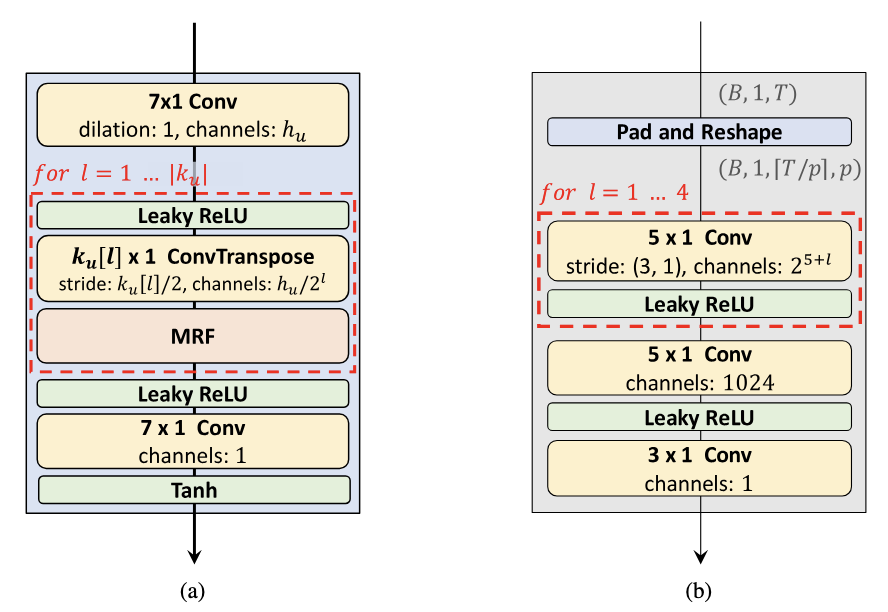
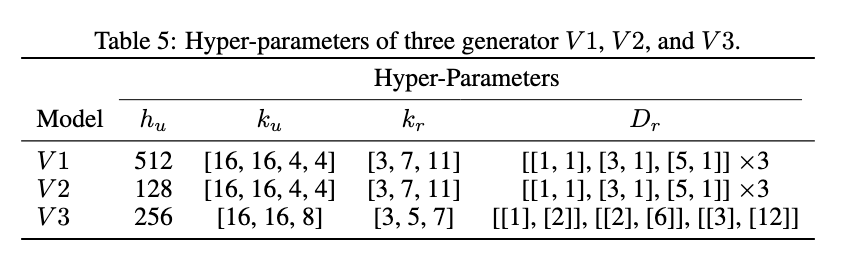

In the HiFiGaN used in XTTS they use ResBlock type 1.

We could use V3 which is 1 conv and 1 residual connection stacked twice. TODO: Could be interesting to see the impact of playing with this on speed and performance of the model.

![CleanShot 2024-10-19 at 09.07.31@2x.png](<attachment:CleanShot 2024-10-19 at 09.07.31@2x.png>)
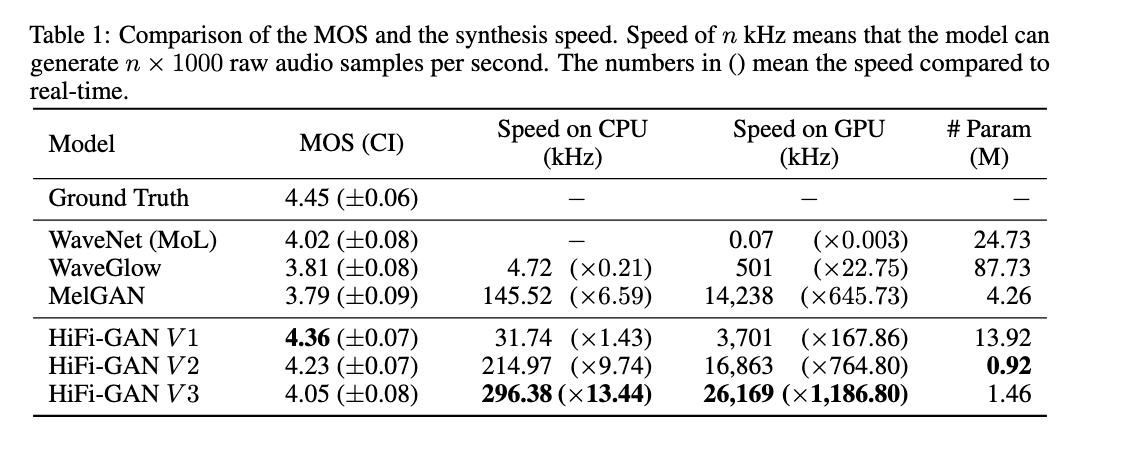

Finally the MRF mentionned looks like this :

![CleanShot 2024-10-19 at 09.31.59@2x.png](<attachment:CleanShot 2024-10-19 at 09.31.59@2x.png>)

This doesn't really seem to do what is implemented in the code...
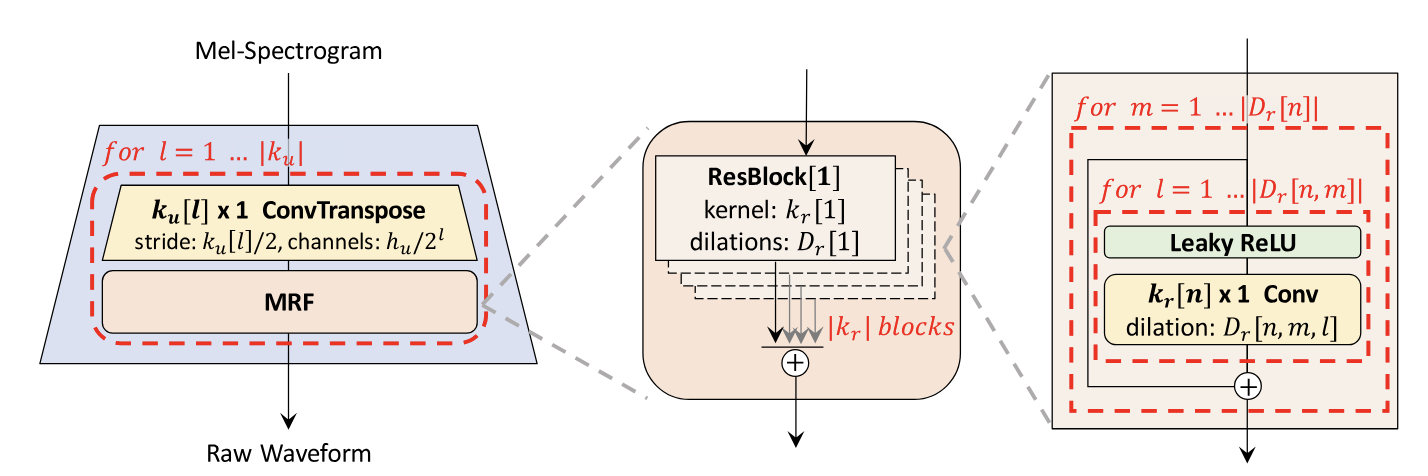

In [10]:
import jax
import equinox as eqx
import equinox.nn as nn

def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)

LRELU_SLOPE = 0.1

class ResBlock1(eqx.Module):
    layers: list

    def __init__(self, chan_in, kernel_size, dilations=[[1, 1], [3, 1], [5, 1]], key=None):
        self.layers = []

        for dilation in dilations:
            smol_layers = []
            for i in range(len(dilation)):
                key, grab = jax.random.split(key, 2)
                smol_layers.append(
                    nn.Conv1d(chan_in, chan_in, 
                            kernel_size=kernel_size, stride=1, 
                            dilation=dilation[i], padding=get_padding(kernel_size, dilation[i]), key=grab)
                )
            self.layers.append(smol_layers)
    
    def __call__(self, x):
        for smol_layer in self.layers:
            y = x
            for conv in smol_layer:
                y = jax.nn.leaky_relu(y, LRELU_SLOPE)
                y = conv(y)
            x = x + y

        return x

So from my understanding this only takes in a vector with varying amounts of channels to do calculations on. 

In [16]:
@jax.jit
def loss(model, x, y):
    res = jax.vmap(model)(x)
    return jax.numpy.mean((res - y) ** 2)

loss = jax.grad(loss, allow_int=True)


key = jax.random.PRNGKey(seed=69)
key1, key2, key3 = jax.random.split(key, 3)

x = jax.random.normal(key1, (10, 80, 256)).astype(jax.numpy.float32)
y = jax.random.normal(key2, (10, 80, 256)).astype(jax.numpy.float32)

model = ResBlock1(80, 3, key=key3)

grads = loss(model, x, y)

